## Bone Marrow Transplant Survival Prediction Using Machine Learning

**Dataset:** ["Bone Marrow Transplant: Children" (UCI Machine Learning Repository)](https://archive.ics.uci.edu/dataset/565/bone+marrow+transplant+children)  

### Data Mining Final Project, Dec 2024, Tarbiat Modares University
Supervisor: **Dr. Toktam Khatibi**

Students: **Matineh Rangzan**, **Maryam Mokarizadeh**

## 0. Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from IPython.display import Image, display
import seaborn as sns

## 1. Introduction

### 1.1. Dataset Overview

The **Bone Marrow Transplant Dataset** contains data on pediatric patients with blood diseases who underwent stem cell transplants. The dataset consists of multiple features, including demographic, clinical, and laboratory data.

Instances: 187
Features: 36

- **Objective**: The primary aim is to predict survival outcomes (binary classification: survival or non-survival).

- **Features**:

![Table Description](table.png)

- **Target Variable**:
  - **survival_status**: Binary indicator of patient survival.

This dataset includes both numerical and categorical variables, some of which require preprocessing, including imputation of missing values, normalization, and encoding.

## 2. Preprocessing

### 2.1. Load and Preprocess Data

In [1]:
# Load the dataset
file_path = 'bone-marrow.csv'
df = pd.read_csv(file_path)

NameError: name 'pd' is not defined

In [ ]:
df.shape # Check the shape of the dataset

(187, 37)

In [ ]:
df.head() # Check the first few rows of the dataset

,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,extcGvHD,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,survival_status
0,1,1,22.830137,0,1,0,1,1,1,0,...,1,7.20,1.338760,5.38,35.0,19,51,32,999,0
1,1,0,23.342466,0,1,0,-1,-1,1,0,...,1,4.50,11.078295,0.41,20.6,16,37,1000000,163,1
2,1,0,26.394521,0,1,0,-1,-1,1,0,...,1,7.94,19.013230,0.42,23.4,23,20,1000000,435,1
3,0,0,39.684932,1,1,0,1,2,1,1,...,?,4.25,29.481647,0.14,50.0,23,29,19,53,1
4,0,1,33.358904,0,0,0,1,2,0,1,...,1,51.85,3.972255,13.05,9.0,14,14,1000000,2043,0


### 2.1.1. Drop Irrelevant Columns
Drop irrelevant or redundant columns based on domain knowledge

In [ ]:
# Choose column dropping option based on the goal
COLUMN_DROPPING_OPTION = 'option1'  # Options: 'option1' or 'option2'

if COLUMN_DROPPING_OPTION == 'option1':
    # Option 1: Drop columns that are not suitable for prediction
    # - 'Recipientage10', 'Recipientageint', 'Donorage35': Redundant age-related information that doesn't add predictive value.
    # - 'time_to_aGvHD_III_IV': Dropped due to noisy extreme values (e.g., 1000000).
    # - 'survival_time': Outcome variable directly tied to the target (survival_status), which could lead to data leakage.
    df.drop(['Recipientage10', 'Recipientageint', 'Donorage35', 'time_to_aGvHD_III_IV', 'survival_time'], axis=1, inplace=True)
    print("Columns dropped using Option 1: Irrelevant variables excluded.")
elif COLUMN_DROPPING_OPTION == 'option2':
    # Option 2: Drop columns that are post-transplant variables and not available at the time of prediction
    df.drop(['Recipientage10', 'Recipientageint', 'Donorage35', 'IIIV', 'Txpostrelapse', 
             'ANCrecovery', 'PLTrecovery', 'time_to_aGvHD_III_IV', 'aGvHDIIIIV', 'extcGvHD', 
             'Relapse', 'survival_time'], axis=1, inplace=True)
    print("Columns dropped using Option 2: Post-transplant variables excluded.")
else:
    raise ValueError("Invalid column dropping option. Choose 'option1' or 'option2'.")

Columns dropped using Option 1: Irrelevant variables excluded.


### 2.1.2. Replace '?' with NaN

In [ ]:
df.nunique().sort_values(ascending=False) # Number of unique values in each column

Donorage           187
CD34kgx10d6        183
CD3dCD34           182
CD3dkgx10d8        163
Rbodymass          130
Recipientage       125
PLTrecovery         50
ANCrecovery         18
HLAgrI               7
Alel                 6
RecipientABO         5
Antigen              5
CMVstatus            5
Disease              5
HLAmatch             4
DonorABO             4
DonorCMV             3
extcGvHD             3
ABOmatch             3
RecipientRh          3
RecipientCMV         3
aGvHDIIIIV           2
Recipientgender      2
Relapse              2
HLAmismatch          2
Stemcellsource       2
Diseasegroup         2
Txpostrelapse        2
Riskgroup            2
Gendermatch          2
IIIV                 2
survival_status      2
dtype: int64

In [ ]:
df['ABOmatch'].unique() # Check unique values in a column

array(['0', '1', '?'], dtype=object)

So beside `NaN` values we also have `?`. Thus, we replace them with `NaN`.

In [ ]:
# Replace placeholder '?' with NaN for proper missing value handling
df.replace('?', np.nan, inplace=True)

### 2.1.3. Encode Categorical Data

In [ ]:
df.dtypes # Check the data types of the columns

Recipientgender      int64
Stemcellsource       int64
Donorage           float64
IIIV                 int64
Gendermatch          int64
DonorABO             int64
RecipientABO        object
RecipientRh         object
ABOmatch            object
CMVstatus           object
DonorCMV            object
RecipientCMV        object
Disease             object
Riskgroup            int64
Txpostrelapse        int64
Diseasegroup         int64
HLAmatch             int64
HLAmismatch          int64
Antigen             object
Alel                object
HLAgrI               int64
Recipientage       float64
Relapse              int64
aGvHDIIIIV           int64
extcGvHD            object
CD34kgx10d6        float64
CD3dCD34           float64
CD3dkgx10d8        float64
Rbodymass          float64
ANCrecovery          int64
PLTrecovery          int64
survival_status      int64
dtype: object

In [ ]:
# Display unique values of columns that are of object type
for column in df.select_dtypes(include=['object']).columns:
    print(f"Unique values in '{column}': {df[column].unique()}")

Unique values in 'RecipientABO': ['1' '-1' '2' '0' nan]
Unique values in 'RecipientRh': ['1' '0' nan]
Unique values in 'ABOmatch': ['0' '1' nan]
Unique values in 'CMVstatus': ['3' '0' '2' '1' nan]
Unique values in 'DonorCMV': ['1' '0' nan]
Unique values in 'RecipientCMV': ['1' '0' nan]
Unique values in 'Disease': ['ALL' 'AML' 'chronic' 'nonmalignant' 'lymphoma']
Unique values in 'Antigen': ['-1' '1' '0' '2' nan]
Unique values in 'Alel': ['-1' '0' '2' '1' '3' nan]
Unique values in 'extcGvHD': ['1' nan '0']


In [ ]:
# One-hot encode the 'Disease' column
df = pd.get_dummies(df, columns=['Disease'], prefix='Disease')
df.head()

,Recipientgender,Stemcellsource,Donorage,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,CMVstatus,...,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,survival_status,Disease_ALL,Disease_AML,Disease_chronic,Disease_lymphoma,Disease_nonmalignant
0,1,1,22.830137,1,0,1,1,1,0,3,...,5.38,35.0,19,51,0,1,0,0,0,0
1,1,0,23.342466,1,0,-1,-1,1,0,0,...,0.41,20.6,16,37,1,1,0,0,0,0
2,1,0,26.394521,1,0,-1,-1,1,0,2,...,0.42,23.4,23,20,1,1,0,0,0,0
3,0,0,39.684932,1,0,1,2,1,1,1,...,0.14,50.0,23,29,1,0,1,0,0,0
4,0,1,33.358904,0,0,1,2,0,1,0,...,13.05,9.0,14,14,0,0,0,1,0,0


In [ ]:
df.dtypes # Check the data types of the columns after encoding

Recipientgender           int64
Stemcellsource            int64
Donorage                float64
IIIV                      int64
Gendermatch               int64
DonorABO                  int64
RecipientABO             object
RecipientRh              object
ABOmatch                 object
CMVstatus                object
DonorCMV                 object
RecipientCMV             object
Riskgroup                 int64
Txpostrelapse             int64
Diseasegroup              int64
HLAmatch                  int64
HLAmismatch               int64
Antigen                  object
Alel                     object
HLAgrI                    int64
Recipientage            float64
Relapse                   int64
aGvHDIIIIV                int64
extcGvHD                 object
CD34kgx10d6             float64
CD3dCD34                float64
CD3dkgx10d8             float64
Rbodymass               float64
ANCrecovery               int64
PLTrecovery               int64
survival_status           int64
Disease_

### 2.1.4. Detect Outliers

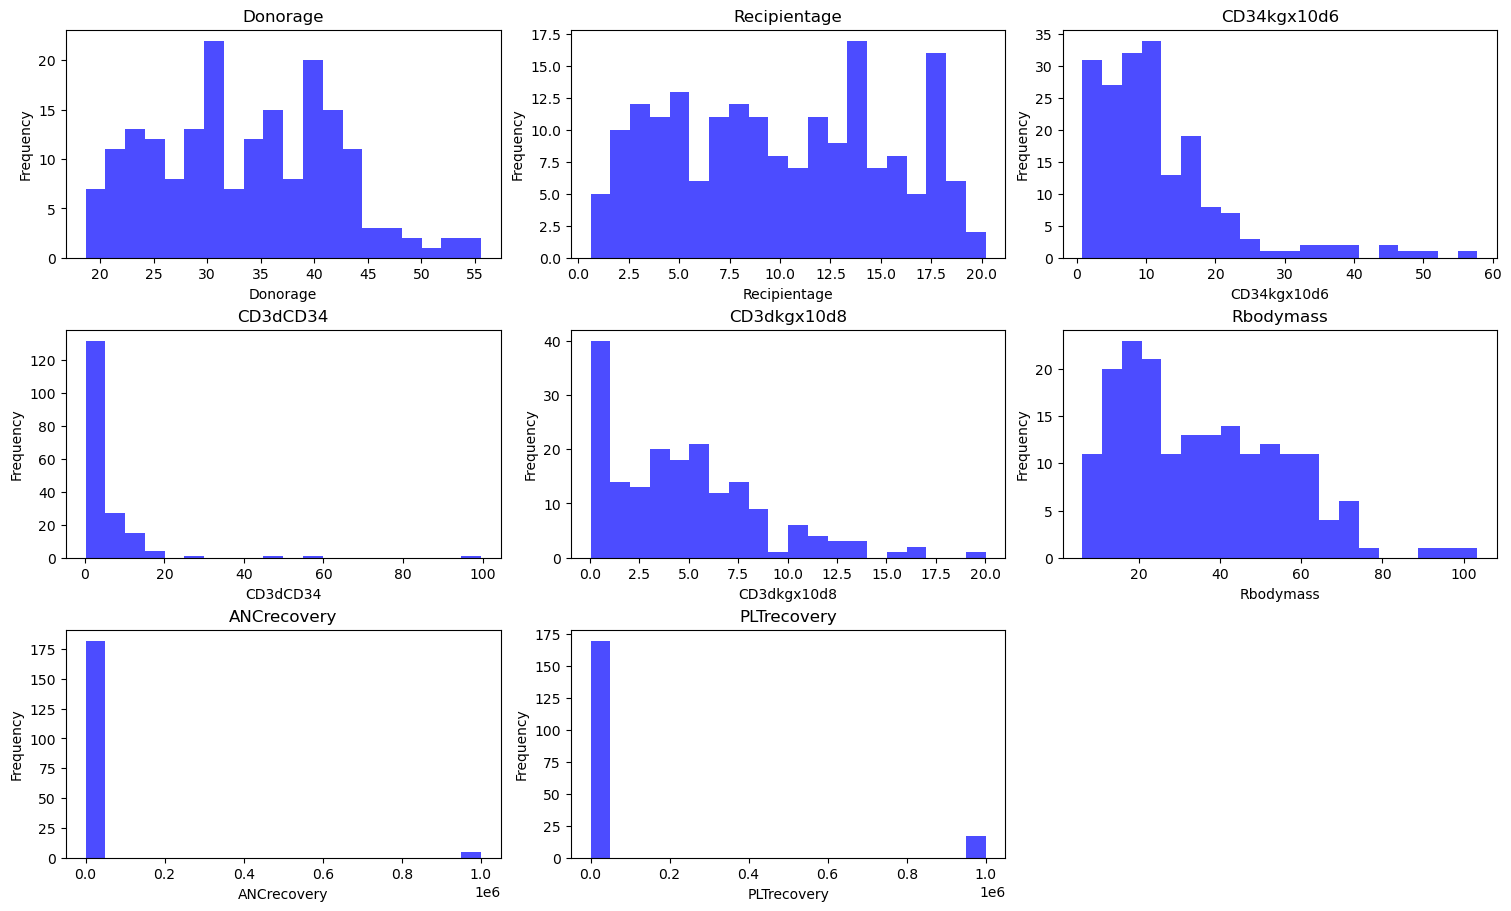

In [ ]:
# Filter columns with more than 10 unique values
columns_to_plot = df.nunique()[df.nunique() > 10].index

# Define number of rows and columns for the grid
num_cols = 3  # Number of histograms per row
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols  # Calculate required rows

# Create subplots with smaller size and grid layout for histograms
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3), constrained_layout=True)

# Flatten the axes for easy iteration
axes = axes.flatten()

# Create histograms
for i, column in enumerate(columns_to_plot):
    axes[i].hist(df[column].dropna(), bins=20, alpha=0.7, color='blue')  # Histogram with 20 bins
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.show()

In [ ]:
# Detect outliers using IQR for specific columns
def detect_outliers_iqr(df, columns):
    outlier_report = {}  # Store outliers for each column
    for column in columns:
        Q1 = df[column].quantile(0.25)  # First quartile
        Q3 = df[column].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile range

        # Define outlier bounds
        lower_bound = Q1 - 2.5 * IQR
        upper_bound = Q3 + 2.5 * IQR

        # Detect outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        if not outliers.empty:
            outlier_report[column] = outliers[[column]].values.tolist()
    
    # Print results
    if outlier_report:
        for col, values in outlier_report.items():
            print(f"Outliers detected in '{col}': {len(values)} rows (values: {values})")
    else:
        print("No outliers detected in the dataset.")

# Run the outlier detection for columns_to_plot
detect_outliers_iqr(df, columns_to_plot)

Outliers detected in 'CD34kgx10d6': 5 rows (values: [[51.85], [57.78], [43.96], [44.0], [48.63]])
Outliers detected in 'CD3dCD34': 8 rows (values: [[19.01323], [29.481647], [16.186239], [47.869839], [99.56097], [56.065024], [19.210978], [16.32616]])
Outliers detected in 'CD3dkgx10d8': 1 rows (values: [[20.02]])
Outliers detected in 'ANCrecovery': 5 rows (values: [[1000000], [1000000], [1000000], [1000000], [1000000]])
Outliers detected in 'PLTrecovery': 27 rows (values: [[1000000], [112], [285], [1000000], [1000000], [107], [1000000], [1000000], [119], [170], [1000000], [1000000], [111], [1000000], [1000000], [189], [91], [1000000], [1000000], [1000000], [1000000], [1000000], [1000000], [1000000], [247], [100], [1000000]])


In [ ]:
df[columns_to_plot].describe() # Summary statistics for the selected columns

,Donorage,Recipientage,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery
count,187.000000,187.000000,187.000000,182.000000,182.000000,185.000000,187.000000,187.000000
mean,33.472068,9.931551,11.891781,5.385096,4.745714,35.801081,26752.866310,90937.919786
std,8.271826,5.305639,9.914386,9.598716,3.859128,19.650922,161747.200525,288242.407688
min,18.646575,0.600000,0.790000,0.204132,0.040000,6.000000,9.000000,9.000000
25%,27.039726,5.050000,5.350000,1.786683,1.687500,19.000000,13.000000,16.000000
50%,33.550685,9.600000,9.720000,2.734462,4.325000,33.000000,15.000000,21.000000
75%,40.117809,14.050000,15.415000,5.823565,6.785000,50.600000,17.000000,37.000000
max,55.553425,20.200000,57.780000,99.560970,20.020000,103.400000,1000000.000000,1000000.000000


In [ ]:
# Outlier detection and removal using IQR method
for column in columns_to_plot:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2.5 * IQR
    upper_bound = Q3 + 2.5 * IQR
    
    # Remove outliers
    df = df[~((df[column] < lower_bound) | (df[column] > upper_bound))]

# Display the dataframe after removing outliers

In [ ]:
df.shape # Check the shape of the dataset after outlier removal

(145, 36)

## 2.2. Split Dataset

In [ ]:
# Split the dataset into training and testing sets before handling missing values
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## 2.3. Handle Missing Values

In [ ]:
# How many null values are there in each column
df.isnull().sum().sort_values(ascending=False)
# None of the columns have missing values more than 20% of the total rows.

extcGvHD                13
CMVstatus                9
RecipientCMV             8
CD3dCD34                 4
CD3dkgx10d8              4
Rbodymass                2
RecipientRh              2
Antigen                  1
Alel                     1
ABOmatch                 1
RecipientABO             1
DonorCMV                 1
aGvHDIIIIV               0
survival_status          0
PLTrecovery              0
ANCrecovery              0
Disease_ALL              0
Disease_AML              0
Disease_chronic          0
Disease_lymphoma         0
CD34kgx10d6              0
Recipientgender          0
Relapse                  0
Recipientage             0
HLAgrI                   0
Stemcellsource           0
HLAmismatch              0
HLAmatch                 0
Diseasegroup             0
Txpostrelapse            0
Riskgroup                0
DonorABO                 0
Gendermatch              0
IIIV                     0
Donorage                 0
Disease_nonmalignant     0
dtype: int64

### 2.3.1. Impute Missing Values

In [ ]:
# Choose between 'mean' and 'knn' for imputation
IMPUTATION_METHOD = 'mean'  # Options: 'mean' or 'knn'

if IMPUTATION_METHOD == 'mean':
    # Fit the imputer only on the training data to avoid data leakage
    mean_imputer = SimpleImputer(strategy='mean')
    train_df_imputed = pd.DataFrame(mean_imputer.fit_transform(train_df), columns=train_df.columns)
    
    # Transform the test data using statistics computed from the training data
    test_df_imputed = pd.DataFrame(mean_imputer.transform(test_df), columns=test_df.columns)
    print("Missing values imputed using Mean.")
    
elif IMPUTATION_METHOD == 'knn':
    # Fit KNN Imputer only on the training data
    knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
    train_df_imputed = pd.DataFrame(knn_imputer.fit_transform(train_df), columns=train_df.columns)
    
    # Transform the test data using the neighbors defined by the training data
    test_df_imputed = pd.DataFrame(knn_imputer.transform(test_df), columns=test_df.columns)
    print("Missing values imputed using KNN.")

Missing values imputed using Mean.


## 2.4. Normalize Data

In [ ]:
# Normalize numerical data separately for training and testing datasets
scaler = MinMaxScaler()
train_df_imputed[train_df_imputed.columns] = scaler.fit_transform(train_df_imputed[train_df_imputed.columns])
test_df_imputed[test_df_imputed.columns] = scaler.transform(test_df_imputed[test_df_imputed.columns])

## 2.5. Separate Features and Target

In [ ]:
# Separate features and target variable
X_train = train_df_imputed.drop('survival_status', axis=1) # Features
y_train = train_df_imputed['survival_status'] # Target variable
X_test = test_df_imputed.drop('survival_status', axis=1) # Features
y_test = test_df_imputed['survival_status'] # Target variable

## 2.6. Feature Selection

In [ ]:
# Use SelectKBest to select the top 10 features based on ANOVA F-statistic
selector = SelectKBest(score_func=f_classif, k=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

## 2.7. Handle Imbalance

In [ ]:
# How many of survival_status are 0 and 1
df['survival_status'].value_counts() # 0: Alive, 1: Dead

0    87
1    58
Name: survival_status, dtype: int64

In [ ]:
# Use SMOTE (Synthetic Minority Oversampling Technique) to generate synthetic samples for the minority class
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

# 3. Modeling

## 3.1 Train Models and Evaluate Performance

In [ ]:
# Define models and their hyperparameters
models = {
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Boosting": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
        n_estimators=100,
        learning_rate=0.01,
        random_state=42
    ),
    
    "Bagging": BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
        n_estimators=100,
        max_samples=0.5,
        bootstrap=True,
        random_state=42
    )
}

# Define hyperparameter grids for GridSearchC
param_grids = {
    "Decision Tree": {
        'criterion': ['gini', 'entropy'],
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 2, 4]
    },
    "SVM": {
        'C': [0.01, 0.05, 0.1, 0.5],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    "Boosting": {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    "Bagging": {
        'n_estimators': [50, 100, 150],
        'max_samples': [0.3, 0.5]
    }
}

## 3.2. Hyperparameter Tuning and Evaluation


Training Decision Tree...
Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

Training SVM...
Best Parameters for SVM: {'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}

Training Boosting...
Best Parameters for Boosting: {'learning_rate': 0.01, 'n_estimators': 100}

Training Bagging...
Best Parameters for Bagging: {'max_samples': 0.5, 'n_estimators': 100}

Model Performance Summary (option1 , mean):
           Model    Set  Accuracy  Precision    Recall  F1 Score
0  Decision Tree  Train  0.771429   0.885246  0.771429  0.824427
1  Decision Tree   Test  0.862069   0.900000  0.750000  0.818182
2            SVM  Train  0.700000   0.820896  0.785714  0.802920
3            SVM   Test  0.724138   0.666667  0.666667  0.666667
4       Boosting  Train  0.778571   0.811594  0.800000  0.805755
5       Boosting   Test  0.931034   0.916667  0.916667  0.916667
6        Bagging  Train  0.742857   0.985714  0.985714  0.985714
7       

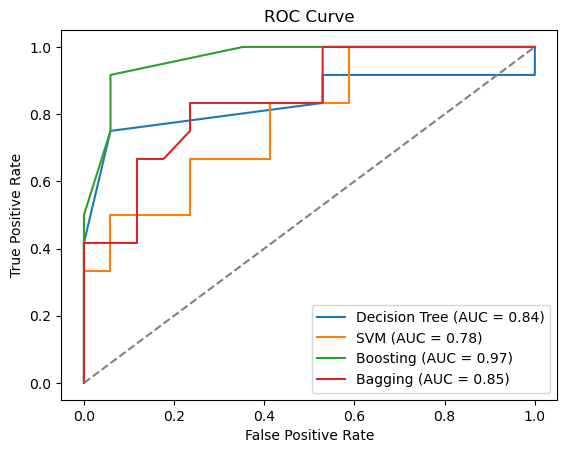

In [ ]:
best_models = {}
results = []
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_balanced, y_train_balanced)

    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    # Training performance
    y_train_pred = best_model.predict(X_train_balanced)
    train_accuracy = grid_search.best_score_
    train_precision = precision_score(y_train_balanced, y_train_pred)
    train_recall = recall_score(y_train_balanced, y_train_pred)
    train_f1 = f1_score(y_train_balanced, y_train_pred)

    results.append({
        "Model": model_name,
        "Set": "Train",
        "Accuracy": train_accuracy,
        "Precision": train_precision,
        "Recall": train_recall,
        "F1 Score": train_f1
    })

    # Testing performance
    y_test_pred = best_model.predict(X_test_selected)
    y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1] if hasattr(best_model, 'predict_proba') else None

    test_accuracy = best_model.score(X_test_selected, y_test)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    results.append({
        "Model": model_name,
        "Set": "Test",
        "Accuracy": test_accuracy,
        "Precision": test_precision,
        "Recall": test_recall,
        "F1 Score": test_f1
    })

    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")

    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc(fpr, tpr):.2f})")

# Display results as a table
results_df = pd.DataFrame(results)
print(f"\nModel Performance Summary ({COLUMN_DROPPING_OPTION} , {IMPUTATION_METHOD}):")
print(results_df)

# # Finalize and show ROC (Receiver Operating Characteristic) curve
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# 4. Results and Discussion

## 4.1. Plot Confusion Matrix

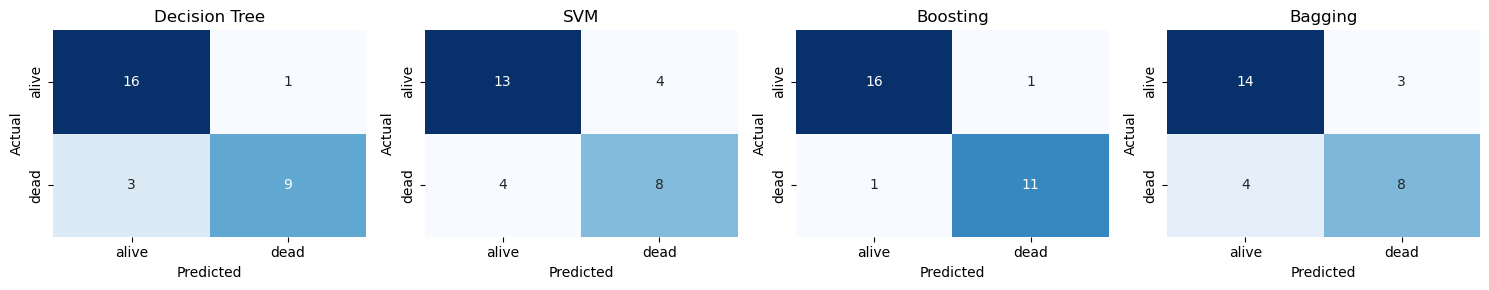

In [ ]:
# Plot confusion matrix for all models with heatmap in a single row
fig, axes = plt.subplots(1, len(best_models), figsize=(15, 3))  # Adjust the size as needed

for ax, (model_name, best_model) in zip(axes, best_models.items()):
    y_pred_best = best_model.predict(X_test_selected)
    conf_matrix = confusion_matrix(y_test, y_pred_best)
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['alive', 'dead'])
    ax.set_yticklabels(['alive', 'dead'])

plt.tight_layout()
plt.show()

## 4.2. Visualize Decision Tree

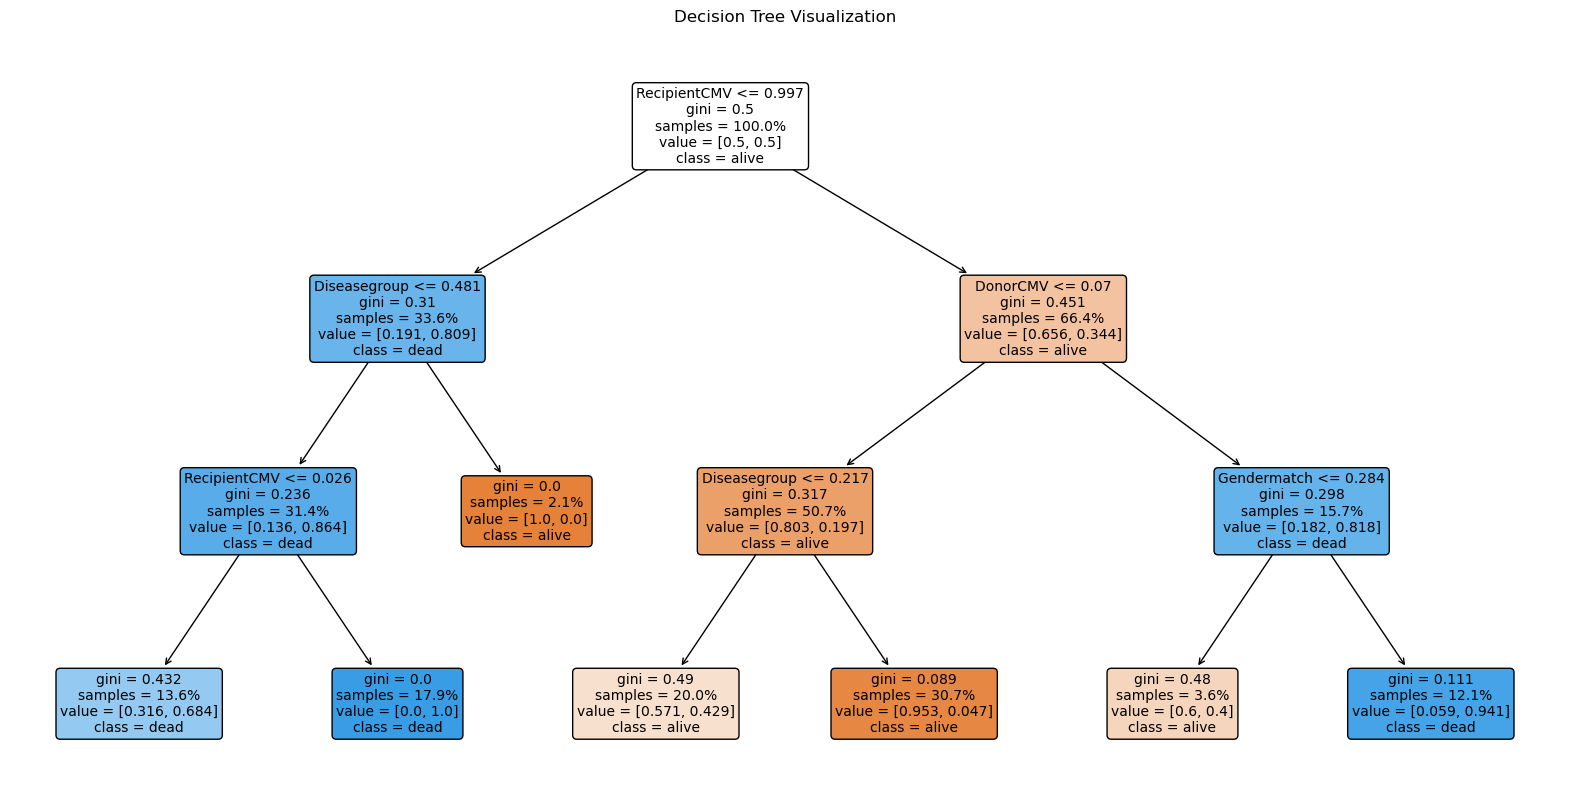

In [ ]:
# Visualize the best decision tree
best_tree_model = best_models["Decision Tree"]

plt.figure(figsize=(20, 10))
plot_tree(
    best_tree_model,
    feature_names=X_train.columns,  # Use feature names for readability
    class_names=["alive", "dead"],  # Class 0: alive, Class 1: dead
    filled=True,  # Color the nodes
    rounded=True,  # Rounded boxes for nodes
    proportion=True,  # Show proportions at each node
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()

## 4.3. Results and Discussion

#### Model Performance Summary (Option1 with Mean)  
- **Decision Tree**:  
  - **Train**: Strong performance (F1 = 0.82, Precision = 0.89).  
  - **Test**: Improved generalization with better recall (F1 = 0.82, Recall = 0.75).  
- **SVM**:  
  - **Train**: Balanced performance (F1 = 0.80, Recall = 0.79).  
  - **Test**: Shows stable generalization (F1 = 0.67, Precision = 0.67).  
- **Boosting**:  
  - **Train**: Excellent performance (F1 = 0.81, Recall = 0.80).  
  - **Test**: Best generalization, maintaining high precision and recall (F1 = 0.92, Recall = 0.92).  
- **Bagging**:  
  - **Train**: Very strong performance (F1 = 0.99, Recall = 0.99), indicating possible overfitting.  
  - **Test**: Better generalization but still some overfitting (F1 = 0.70, Recall = 0.67). 
 
**Insight**: Boosting provides the best balance between training and test performance, achieving high recall and precision. Decision Tree and SVM show stable generalization, while Bagging still tends to overfit but generalizes better than before.  


In [ ]:
# Model Performance Summary (option1 , knn):
#            Model    Set  Accuracy  Precision    Recall  F1 Score
# 0  Decision Tree  Train  0.750000   0.881356  0.742857  0.806202
# 1  Decision Tree   Test  0.827586   0.888889  0.666667  0.761905
# 2            SVM  Train  0.692857   0.811594  0.800000  0.805755
# 3            SVM   Test  0.689655   0.636364  0.583333  0.608696
# 4       Boosting  Train  0.742857   0.805970  0.771429  0.788321
# 5       Boosting   Test  0.896552   0.909091  0.833333  0.869565
# 6        Bagging  Train  0.714286   0.984848  0.928571  0.955882
# 7        Bagging   Test  0.724138   0.700000  0.583333  0.636364

- **Accuracy**: Percentage of correctly classified samples.  
- **Precision**: Percentage of positive predictions that are correct.  
- **Recall**: Percentage of actual positives correctly identified.  
- **F1 Score**: Harmonic mean of Precision and Recall, balancing both metrics.

Option 1 (Including Post-Transplant Features):

- Models perform better due to the **inclusion of post-transplant** variables, which are strong predictors of survival outcomes.
- **Mean imputation** provides slightly better stability than KNN.
- **Boosting** shows the best balance between training and testing performance.
- **SVM** and **Decision Tree** show moderate generalization, while **Bagging** slightly overfits but remains competitive.

Option 2 (Excluding Post-Transplant Features - Stricter):

- Test performance drops significantly due to **removal of post-transplant** variables, which limits predictive information.
- **Boosting** struggles to maintain its advantage, and other models fail to generalize effectively.  
- **KNN imputation** is slightly better than mean, but the overall feature set remains too weak for effective learning.  

In [ ]:
# Model Performance Summary (option1 , knn):
#            Model    Set  Accuracy  Precision    Recall  F1 Score
# 0  Decision Tree  Train  0.750000   0.881356  0.742857  0.806202
# 1  Decision Tree   Test  0.827586   0.888889  0.666667  0.761905
# 2            SVM  Train  0.692857   0.811594  0.800000  0.805755
# 3            SVM   Test  0.689655   0.636364  0.583333  0.608696
# 4       Boosting  Train  0.742857   0.805970  0.771429  0.788321
# 5       Boosting   Test  0.896552   0.909091  0.833333  0.869565
# 6        Bagging  Train  0.714286   0.984848  0.928571  0.955882
# 7        Bagging   Test  0.724138   0.700000  0.583333  0.636364

##############################################################################################

# Model Performance Summary (option1 , mean):
#            Model    Set  Accuracy  Precision    Recall  F1 Score
# 0  Decision Tree  Train  0.771429   0.885246  0.771429  0.824427
# 1  Decision Tree   Test  0.862069   0.900000  0.750000  0.818182
# 2            SVM  Train  0.700000   0.820896  0.785714  0.802920
# 3            SVM   Test  0.724138   0.666667  0.666667  0.666667
# 4       Boosting  Train  0.778571   0.811594  0.800000  0.805755
# 5       Boosting   Test  0.931034   0.916667  0.916667  0.916667
# 6        Bagging  Train  0.742857   0.985714  0.985714  0.985714
# 7        Bagging   Test  0.758621   0.727273  0.666667  0.695652

##############################################################################################

# Model Performance Summary (option2 , knn):
#            Model    Set  Accuracy  Precision    Recall  F1 Score
# 0  Decision Tree  Train  0.586667   0.783333  0.626667  0.696296
# 1  Decision Tree   Test  0.400000   0.230769  0.214286  0.222222
# 2            SVM  Train  0.613333   0.700000  0.560000  0.622222
# 3            SVM   Test  0.457143   0.272727  0.214286  0.240000
# 4       Boosting  Train  0.586667   0.816901  0.773333  0.794521
# 5       Boosting   Test  0.542857   0.428571  0.428571  0.428571
# 6        Bagging  Train  0.653333   0.901408  0.853333  0.876712
# 7        Bagging   Test  0.428571   0.312500  0.357143  0.333333

############################################################################################

# Model Performance Summary (option2 , mean):
#            Model    Set  Accuracy  Precision    Recall  F1 Score
# 0  Decision Tree  Train  0.620000   0.957746  0.906667  0.931507
# 1  Decision Tree   Test  0.400000   0.230769  0.214286  0.222222
# 2            SVM  Train  0.626667   0.704225  0.666667  0.684932
# 3            SVM   Test  0.457143   0.333333  0.357143  0.344828
# 4       Boosting  Train  0.580000   0.746269  0.666667  0.704225
# 5       Boosting   Test  0.457143   0.352941  0.428571  0.387097
# 6        Bagging  Train  0.640000   0.914286  0.853333  0.882759
# 7        Bagging   Test  0.542857   0.428571  0.428571  0.428571

### Best Performance

- **Classifier**: Boosting  
- **Option**: Option1 (with post-transplant features)  
- **Imputer**: Mean Imputer

**Why**: Boosting demonstrated the best balance between training and testing, maintaining strong generalization and stability. It outperformed other models by effectively capturing patterns in the data while avoiding overfitting, making it the most reliable choice. 

# 5. Future Work

Option 1 is preferable for predictive tasks involving survival outcomes, as it includes critical post-transplant variables.
If strict exclusions are necessary (Option 2), additional strategies are needed to compensate for the loss of predictive power:
- **External Data:** Incorporate supplementary datasets to enhance the input features.
- **Better Classifiers:** Utilize more advanced models like deep learning or ensemble methods (e.g., Gradient Boosting, Random Forests) that can uncover complex patterns in the limited feature space.